## King County House Sales Project Submission

Please fill out:
* Student names: Andrew Boucher, Jon McCaffrey
* Student pace: full time
* Scheduled project review date/time: 10/28/22 15:00 EST
* Instructor name: Daniel Burdeno



In [190]:
# Your code here - remember to use markdown cells for comments as well!

# Overview

For this project, we will be using multiple linear regression modeling to analyze house sales in King County, WA, based on data from May 2014 - May 2015.

# Business Challenge

We will be presenting to a home building and renovation company __[Northwest Builders & Renovation](northwestbnr.com)__ in Seattle, WA.  The premise is they are looking for insight into what features of properties have the greatest impact on sale price.  This information could influence what clients they market to for potential renovation projects as well as what features are most important to consider for new home construction. 

# Data Understanding

## Initial imports

In [191]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import itertools
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import time as time
!pip install haversine
import haversine as hs

## Loaded data, initial exploratory data analysis

We will be transforming our initial dataframe multiple times throughout this notebook.  Here is an initial outline of the process to create our ultimate model from the dataset, with more detail to follow at each step.  Please refer back to this cell if needed to review the process.
- df = initial dataframe
- df2 = adding a timestamp column.  This will be relevant for subsetting resale properties later.
- df3 = adding distance to downtown Seattle, in miles, based on each location's latitude & longitude
- df4 = creating separate smaller dataframe with only the column for "condition", prior to ordinal encoding
- df5 = the dataframe for "condition" after ordinal encoding
- df6 = concatenating ordinal-encoded "condition" back together with main dataframe (df3 at this point)
- df7 = creating a dataframe of only "numeric" data types
- df8 = removing irrelevant or misleading numeric qualities
- df9 = removing top ~2% of outliers for sqft_lot15 column
- df10 = removing top ~2% of outliers for price.  This is the dataframe our main multiple regression model is modeled on.  

In [192]:
# establishing initial dataframe
df = pd.read_csv('./data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [193]:
# checking size of initial dataframe
df.shape

(21597, 21)

In [194]:
# Exploring the size of the data set, data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Some of the features above may require an alteration in data type for better evaluation as either a continuous or discrete variable, for potentially fitting to our model.
- date: entered as a string in the dataframe
- zipcode: entered as a numeric but may be more suitable to consider as a discrete / categorical variable
- grade: may require one hot encoding, or ordinal encoding, for comparison as a numeric
- condition: may require ordinal encoding for comparison as a numeric

We eventually chose "condition" as one categorical feature to explore, partially to avoid adding too many more features with one hot encoding or ordinal encoding ALL categorical variables, and we will explain why we it was the most relevant categorical feature for us to explore.  

As an example, to illustrate value counts we would have to consider with multiple categorical features to transform:

In [195]:
len(df['zipcode'].value_counts()), len(df['view'].value_counts()), len(df['waterfront'].value_counts()), len(df['grade'].value_counts())

# the number of zipcodes, "view" categories, "waterfront" categories (yes/no), and "grade" categories:

(70, 5, 2, 11)

In [196]:
# obtaining statistics for numeric columns
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Noted likely outliers for price, bedrooms and sqft_lot15, based on the wide margins between the 75th percentile and the max quantity entered.  Will address below

In [197]:
# checking for null values
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

We noted a large amount of null values in the "waterfront" and "yr_renovated" columns

In [198]:
# looking at correlation for numeric portion of dataframe
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.022137,-0.261570,-0.001199,0.344842,0.731767,0.195077
yr_built,0.021617,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.225209,-0.347210,-0.148370,0.409993,0.326377,0.070777
yr_renovated,-0.012010,0.129599,0.018495,0.051050,0.055660,0.004513,0.003535,0.022137,-0.225209,1.000000,0.069846,0.032145,-0.072156,-0.000247,0.003852


That's a lot of information to absorb.  Here's an annotated visual to make it a *little* easier to read

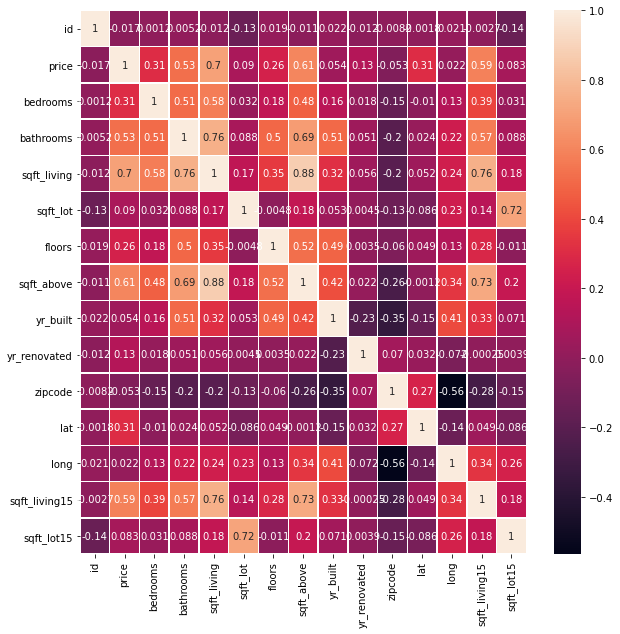

In [199]:
# producing a heatmap of correlations
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, linewidths=.5, ax=ax);

We want to include as many numeric features as we can and would like to include as many relevant categorical features as well to improve our model.  We can highlight the significant correlations to our target category "price" below, as most will be included in our future modeling:

In [200]:
df.corr()['price']

id              -0.016772
price            1.000000
bedrooms         0.308787
bathrooms        0.525906
sqft_living      0.701917
sqft_lot         0.089876
floors           0.256804
sqft_above       0.605368
yr_built         0.053953
yr_renovated     0.129599
zipcode         -0.053402
lat              0.306692
long             0.022036
sqft_living15    0.585241
sqft_lot15       0.082845
Name: price, dtype: float64

We can put those values in descending order, and looking at absolute values, below:

In [201]:
df.corr()['price'].map(abs).sort_values(ascending=False)

price            1.000000
sqft_living      0.701917
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
bedrooms         0.308787
lat              0.306692
floors           0.256804
yr_renovated     0.129599
sqft_lot         0.089876
sqft_lot15       0.082845
yr_built         0.053953
zipcode          0.053402
long             0.022036
id               0.016772
Name: price, dtype: float64

This is where it starts to become apparent which features may have the greatest impact on our target "price", but we will have to consider the quality of the data, potential multicollinearity, or simply overlap in what each feature is representing.  

## Checking date range in data set¶

In [202]:
pd.to_datetime(df['date']).min()

Timestamp('2014-05-02 00:00:00')

In [203]:
pd.to_datetime(df['date']).max()

Timestamp('2015-05-27 00:00:00')

# Data Preparation

## Create a new column that converts date into a time stamp

In [204]:
# df2 - added timestamp
# creating new column that converts date into a time stamp which is the 
# number of seconds since 1/1/1970 (aka UTC)
df2 = df.copy()
df2['time_stamp'] = [time.mktime(time.strptime(x, '%m/%d/%Y')) for x in df['date']]
df2.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_stamp
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,1.413173e+09
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,1.418101e+09
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,1.424840e+09
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,1.418101e+09
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,1.424236e+09


In [205]:
# sanity check to ensure only one column added to original dataframe
df2.shape

(21597, 22)

# Creating a new dataframe with column for distance from downtown Seattle

Rather than focus on latitude and longitude separately, or try to utilize the zipcodes (which represent areas of vastly different size in no particular ordinal way) we elected to create one numeric column that will represent the distance of each location in the dataframe from a point in downtown Seattle (provided by a __[Google](https://www.google.com/search?q=downtown+Seattle+latitude+longitude&source=lmns&bih=736&biw=888&hl=en&sa=X&ved=2ahUKEwi-95SOmYP7AhUGmVMKHf0lAsIQ_AUoAHoECAEQAA)__ search)

In [206]:
# initializing and formatting location variables
# loc 1 equals lat/long of each house in dataset
# loc 2 equals defined lat/long of Seattle from Google
loc1 = list(zip(df2['lat'], df2['long']))
loc2 = (47.6050, -122.3344)

In [207]:
# df3 - created new column to convert lat/long to distance from downtown Seattle
# in miles
df3 = df2.copy()
df3['dist_Seattle'] = [hs.haversine((x,y), loc2, unit='mi') for x,y in loc1]
df3.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_stamp,dist_Seattle
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,1.413173e+09,7.418041
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,1.418101e+09,8.046810
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,1.424840e+09,10.323554
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,1.418101e+09,6.427255
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,1.424236e+09,13.504920


In [208]:
# confirming only one more column added
df3.shape

(21597, 23)

# Creating a new dataframe with column for ordinal-encoded condition

## Why only the "condition" column?

To recap the potential discrete variables that we would incorporate at this point, we could include "waterfront", "view", "grade", or "condition".

The "waterfront" column is a binary of YES/NO and has 2,376 nulls, which is more than 10% of the total dataset, as well as a vast majority of NO responses

In [209]:
df['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

The "view" column has 5 values, but NONE is the vast majority in that column, representing ~90% of the total dataset.

In [210]:
df['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

The "grade" column seemed promising, based on the distribution of respones.

In [211]:
df['grade'].value_counts().sort_values(ascending=False)

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

We one hot encoded the "grade" column and, unsurprisingly, the highest grades are positively correlated with price.  We did notice 'Average' is slightly negatively correlated and yet 'Better' is positively correlated.  

In [212]:
df_price_grade = pd.concat([df['price'], df['grade']], axis=1)

In [213]:
dummy_price_grade = pd.get_dummies(df_price_grade, drop_first=True)

In [214]:
dummy_price_grade.corr()['price']

price                  1.000000
grade_11 Excellent     0.357589
grade_12 Luxury        0.291068
grade_13 Mansion       0.211806
grade_3 Poor          -0.005155
grade_4 Low           -0.031618
grade_5 Fair          -0.084549
grade_6 Low Average   -0.209463
grade_7 Average       -0.316053
grade_8 Good           0.004576
grade_9 Better         0.235859
Name: price, dtype: float64

What would it take for a home to bump from average to better?  Was that worth pursuing?  The more we read ( __[1](https://www.sapling.com/12067706/grade-mean-tax-assessment#:~:text=Grade%20is%20an%20evaluation%20of%20the%20construction%20materials,Entry-level%20appraisers%20usually%20make%20the%20initial%20grade%20estimate.)__ __[2](https://budgeting.thenest.com/difference-value-appraisal-good-vs-average-23510.html)__ ) about a house's "grade" however, the more we realized it has to do with its original construction and not with renovations.  And though our client does do new homebuilding, they are not in the market of building high-end homes at this time.

So now we'll explore "condition" as an option for a categorical variable to investigate its influence on sale price and possible practical value for our client. Based on the above reading on grade as well, the "condition" feature appears to be a subjective rating applied in real estate appraisals.  
Looking below, there seems to be an adequate distribution of values.  

In [215]:
df['condition'].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [216]:
# ordinal encoding condition
categories = [['Poor', 'Fair', 'Average', 'Good', 'Very Good']]
ords = OrdinalEncoder(categories=categories)

In [217]:
# df4 - create dataframe of only 'condition'
df4 = pd.DataFrame(df3['condition'])

In [218]:
# fit to ordinal encoder and transform
ords.fit(df4)
cond = ords.transform(df4)
cond

array([[2.],
       [2.],
       [2.],
       ...,
       [2.],
       [2.],
       [2.]])

In [219]:
# df5 - new dataframe with ordinal encoding taking place of grade
df5 = pd.DataFrame(cond, df4.index, columns=['ord_cond'])
# reset df5 dataframe to index of df4

In [220]:
# reviewing original categorical values
df4.value_counts()

condition
Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
dtype: int64

In [221]:
# confirming the ordinal-encoded values for "condition" match original
# descriptors
df5.value_counts()

ord_cond
2.0         14020
3.0          5677
4.0          1701
1.0           170
0.0            29
dtype: int64

In [222]:
# df6 - concatenate df3 and df5 (ordinal encoded condition)
df6 = pd.concat([df3, df5], axis=1)
df6.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,1955,0.0,98178,47.5112,-122.257,1340,5650,1.413173e+09,7.418041,2.0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,1.418101e+09,8.046810,2.0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,1933,NaN,98028,47.7379,-122.233,2720,8062,1.424840e+09,10.323554,2.0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1965,0.0,98136,47.5208,-122.393,1360,5000,1.418101e+09,6.427255,4.0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1987,0.0,98074,47.6168,-122.045,1800,7503,1.424236e+09,13.504920,2.0


In [223]:
df6.shape

(21597, 24)

## Trimming dataframe to remove what we've decided are not the most relevant categorical and numeric features

In [224]:
# df7 - creating dataframe with only numeric columns
df7 = df6.select_dtypes(include='number')
df7.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond
0,7129300520,221900.0,3,1.00,1180,5650,1.0,1180,1955,0.0,98178,47.5112,-122.257,1340,5650,1.413173e+09,7.418041,2.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,2170,1951,1991.0,98125,47.7210,-122.319,1690,7639,1.418101e+09,8.046810,2.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,770,1933,NaN,98028,47.7379,-122.233,2720,8062,1.424840e+09,10.323554,2.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,1050,1965,0.0,98136,47.5208,-122.393,1360,5000,1.418101e+09,6.427255,4.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,1680,1987,0.0,98074,47.6168,-122.045,1800,7503,1.424236e+09,13.504920,2.0


We will remove "yr_renovated" before modeling due to the very high null count (3,842)

In [225]:
# number of nulls
df['yr_renovated'].isna().sum()

3842

We will also remove the numeric values of "zipcode", "lat", and "long" in favor of using the distance to downtown Seattle value we've created ("dist_Seattle")

In [226]:
# df8 - created dataframe with only relevant numerics included
df8 = df7.drop(['yr_renovated', 'zipcode', 'lat', 'long'], axis=1)

In [227]:
df8.shape

(21597, 14)

In [228]:
df8.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond
0,7129300520,221900.0,3,1.00,1180,5650,1.0,1180,1955,1340,5650,1.413173e+09,7.418041,2.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,2170,1951,1690,7639,1.418101e+09,8.046810,2.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,770,1933,2720,8062,1.424840e+09,10.323554,2.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,1050,1965,1360,5000,1.418101e+09,6.427255,4.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,1680,1987,1800,7503,1.424236e+09,13.504920,2.0


## Investigating for Outliers

Revisiting the original dataframe (df) we will highlight some potential outliers to consider removing prior to data modeling

In [229]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [230]:
for column in df8.columns:
    rvs = stats.norm(loc=df8[column].mean(), scale=df8[column].std())
    IQR = rvs.ppf(0.75) - rvs.ppf(0.25)
    upper = rvs.ppf(0.75) + (1.5*IQR)
    lower = rvs.ppf(0.25) - (1.5*IQR)
    print([column, lower, upper])

['id', -3180840729.4084797, 12341789304.950453]
['price', -450847.60668237554, 1531440.7536935345]
['bedrooms', 0.8740835415323494, 5.872316421425469]
['bathrooms', 0.04113816755141686, 4.190514376783444]
['sqft_living', -396.690833578044, 4557.334534092004]
['sqft_lot', -96630.18764399773, 126829.00516494972]
['floors', 0.03805435879181829, 2.9501384457643702]
['sqft_above', -444.6650559673178, 4021.8587402753233]
['yr_built', 1891.7464985531415, 2050.252853208677]
['sqft_living15', 137.8965983619844, 3835.3440369114332]
['sqft_lot15', -60827.042639815634, 86343.6096630133]
['time_stamp', 1388215665.5854847, 1440927828.0108483]
['dist_Seattle', -6.31042261892084, 29.308841402496142]
['ord_cond', 0.6546799855346104, 4.164970891902071]


The above is a function that yields the column name and a range of values from 1.5xIQR below the 25th percentile up to 1.5xIQR above the 75th percentile.  To avoid eliminating too much data in our features, we chose to focus on the most significant outliers in our target "price" column, as well as the "sqft_lot15" column.

### Outlier in Bedrooms

We'll highlight the max value for "bedrooms" below.

In [231]:
df8['bedrooms'].value_counts()
# reveals one house with '33' bedrooms

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [232]:
beds_outlier = df8.loc[df8['bedrooms'] > 11]
beds_outlier
# looks like the number '3' entered twice by mistake.  Will impute to '3'

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond
15856,2402100895,640000.0,33,1.75,1620,6000,1.0,1040,1947,1330,4700,1.403669e+09,5.723124,4.0


In [233]:
# Imputing 33 to 3
df8['bedrooms'] = df8['bedrooms'].replace([33], 3)

In [234]:
# checking that it's gone
df8['bedrooms'].describe()

count    21597.000000
mean         3.371811
std          0.904096
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: bedrooms, dtype: float64

### Outliers in sqft_lot15

We'll review the "sqft_lot15" category, then calculate IQR and see how many outliers we would remove if we go 1.5xIQR above the 75th percentile.  

In [235]:
df8['sqft_lot15'].describe()
# large difference between max and 75%

count     21597.000000
mean      12758.283512
std       27274.441950
min         651.000000
25%        5100.000000
50%        7620.000000
75%       10083.000000
max      871200.000000
Name: sqft_lot15, dtype: float64

In [236]:
# freezing sqlot_15 mean and std
rvs_sqft_lot15 = stats.norm(loc=df8['sqft_lot15'].mean(), scale=df8['sqft_lot15'].std())

In [237]:
# calculating interquartile range for sqft_lot15
IQR_sqft_lot15 = rvs_sqft_lot15.ppf(0.75) - rvs_sqft_lot15.ppf(0.25)
IQR_sqft_lot15

36792.663075707234

In [238]:
# calculating outliers via IQR range
upper_sqft_lot15 = rvs_sqft_lot15.ppf(0.75) + (1.5*IQR_sqft_lot15)
upper_sqft_lot15

86343.6096630133

In [239]:
lower_sqft_lot15 = rvs_sqft_lot15.ppf(0.25) - (1.5*IQR_sqft_lot15)
lower_sqft_lot15
# this yields a negative number, 
# so we won't be eliminating any values at the lower end of sqft_lot15 data

-60827.042639815634

In [240]:
# df9 - creating a dataframe with sqft_lot15 values 
# above the upper_sqft_lot15 threshold removed
df9 = df8.drop(df8[df8['sqft_lot15'] >= upper_sqft_lot15].index)

In [241]:
df9.shape

(21190, 14)

In [242]:
len(df8) - len(df9)

407

In [243]:
407 / len(df8)

0.01884520998286799

- That would remove 1.9% of values from df8

## Removing price outliers

We can see some exceptionally highly priced homes in a table just by noticing a doubling in sale price just in the top 25 highest-priced homes

In [244]:
df9['price'].sort_values(ascending=False).head(25)

7245     7700000.0
3910     7060000.0
9245     6890000.0
4407     5570000.0
1446     5350000.0
1313     5300000.0
1162     5110000.0
8085     4670000.0
2624     4500000.0
8629     4490000.0
12358    4210000.0
4145     4000000.0
2083     3850000.0
7028     3800000.0
19002    3800000.0
16288    3710000.0
18467    3650000.0
6502     3650000.0
15241    3640000.0
19133    3640000.0
2862     3600000.0
21560    3570000.0
5874     3420000.0
13954    3400000.0
10435    3400000.0
Name: price, dtype: float64

Here is a visual to show the skew of the outliers.

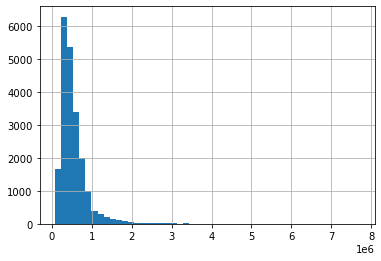

In [245]:
# quick histogram to visualize potential skewness
df9['price'].hist(bins=50);

We can also see mean value (539,000) is much higher than the median value (450,000). 

In [246]:
df9['price'].mean(), df9['price'].median()

(538707.2870221803, 450000.0)

Let's calculate IQR and see how many outliers we would remove if we go 1.5xIQR above the 75th percentile.  

In [247]:
# freezing price mean and std
rvs_price = stats.norm(loc=df9['price'].mean(), scale=df9['price'].std())

In [248]:
# calculating interquartile range for price
IQR_price = rvs_price.ppf(0.75) - rvs_price.ppf(0.25)
IQR_price

495874.44485276565

In [249]:
# calculating outliers via IQR range
upper_price = rvs_price.ppf(0.75) + (1.5*IQR_price)
upper_price

1530456.1767277117

In [250]:
lower_price = rvs_price.ppf(0.25) - (1.5*IQR_price)
lower_price
# this yields a negative number, so we won't be eliminating any values at the lower end of price data

-453041.602683351

In [251]:
# df10 - creating a dataframe with price values above the upper_price 
# threshold removed
df10 = df9.drop(df9[df9['price'] >= upper_price].index)

In [252]:
df10.shape

(20706, 14)

In [253]:
len(df9) - len(df10)

484

In [254]:
(len(df9) - len(df10)) / len(df9)

0.02284096271826333

- So we removed 2.3% of data points based on high price outliers

## Creating Resale Data Frame

At this point, we'll begin creating dataframes that will actually not be used in our primary model, but instead to model information related to resale price.

## Creating a new dataframe which susbsets the original data frame used for modeling (df10) by selecting the houses that were sold more than once

In [255]:
# creating new dataframe df11 with new column added to count the number of
# times a house was sold
df11 = df10.copy()
df11['sale_count'] = df10.groupby('id')['id'].transform('count')

In [256]:
# check new dataframe
df11.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond,sale_count
0,7129300520,221900.0,3,1.00,1180,5650,1.0,1180,1955,1340,5650,1.413173e+09,7.418041,2.0,1
1,6414100192,538000.0,3,2.25,2570,7242,2.0,2170,1951,1690,7639,1.418101e+09,8.046810,2.0,1
2,5631500400,180000.0,2,1.00,770,10000,1.0,770,1933,2720,8062,1.424840e+09,10.323554,2.0,1
3,2487200875,604000.0,4,3.00,1960,5000,1.0,1050,1965,1360,5000,1.418101e+09,6.427255,4.0,1
4,1954400510,510000.0,3,2.00,1680,8080,1.0,1680,1987,1800,7503,1.424236e+09,13.504920,2.0,1


In [257]:
# check on size of new dataframe
df11.shape

(20706, 15)

In [258]:
# check to see distribution of houses sold more than once
df11['sale_count'].value_counts()

1    20363
2      340
3        3
Name: sale_count, dtype: int64

In [259]:
# creating new dataframe df12 that only contains houses sold more than once
df12 = df11.loc[df11['sale_count'] > 1]

In [260]:
# check new data frame
df12.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond,sale_count
93,6021501535,430000.0,3,1.50,1580,5000,1.0,1290,1939,1570,4500,1.406261e+09,6.153774,2.0,2
94,6021501535,700000.0,3,1.50,1580,5000,1.0,1290,1939,1570,4500,1.419311e+09,6.153774,2.0,2
313,4139480200,1380000.0,4,3.25,4290,12103,1.0,2690,1997,3860,11244,1.403064e+09,11.472505,2.0,2
314,4139480200,1400000.0,4,3.25,4290,12103,1.0,2690,1997,3860,11244,1.418101e+09,11.472505,2.0,2
324,7520000520,232000.0,2,1.00,1240,12092,1.0,960,1922,1820,7460,1.409890e+09,7.596381,2.0,2


In [261]:
# checking size of new dataframe
df12.shape

(343, 15)

Creating new dataframe df13 with new column ("dup") for differentiating the 
original and subsequent sales.  The value "True" means it's the second sale
of a house.  "False" means it's the first sale of that property

In [262]:
# creating df13
df13 = df12.copy()
df13['dup'] = df13.duplicated(subset='id')

In [263]:
# check new dataframe
df13.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond,sale_count,dup
93,6021501535,430000.0,3,1.50,1580,5000,1.0,1290,1939,1570,4500,1.406261e+09,6.153774,2.0,2,False
94,6021501535,700000.0,3,1.50,1580,5000,1.0,1290,1939,1570,4500,1.419311e+09,6.153774,2.0,2,True
313,4139480200,1380000.0,4,3.25,4290,12103,1.0,2690,1997,3860,11244,1.403064e+09,11.472505,2.0,2,False
314,4139480200,1400000.0,4,3.25,4290,12103,1.0,2690,1997,3860,11244,1.418101e+09,11.472505,2.0,2,True
324,7520000520,232000.0,2,1.00,1240,12092,1.0,960,1922,1820,7460,1.409890e+09,7.596381,2.0,2,False


In [264]:
# check size of new dataframe
df13.shape

(343, 16)

Creating new dataframe df14 which only contains the first sale of each property.

In [265]:
#creating df14
df14 = df13[df13['dup'] == False]

In [266]:
# checking new dataframe
df14.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond,sale_count,dup
93,6021501535,430000.0,3,1.50,1580,5000,1.0,1290,1939,1570,4500,1.406261e+09,6.153774,2.0,2,False
313,4139480200,1380000.0,4,3.25,4290,12103,1.0,2690,1997,3860,11244,1.403064e+09,11.472505,2.0,2,False
324,7520000520,232000.0,2,1.00,1240,12092,1.0,960,1922,1820,7460,1.409890e+09,7.596381,2.0,2,False
345,3969300030,165000.0,4,1.00,1000,7134,1.0,1000,1943,1020,7138,1.406088e+09,9.102016,2.0,2,False
371,2231500030,315000.0,4,2.25,2180,10754,1.0,1100,1954,1810,6929,1.412136e+09,11.480522,4.0,2,False


In [267]:
# checking size of new dataframe
df14.shape

(171, 16)

Creating new dataframe df15 which now contains only the *repeat* sales of each property.  (One house was sold 3 times within our dataset.)

In [268]:
# creating df15
df15 = df13[df13['dup'] == True]

In [269]:
# checking new dataframe
df15.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond,sale_count,dup
94,6021501535,700000.0,3,1.50,1580,5000,1.0,1290,1939,1570,4500,1.419311e+09,6.153774,2.0,2,True
314,4139480200,1400000.0,4,3.25,4290,12103,1.0,2690,1997,3860,11244,1.418101e+09,11.472505,2.0,2,True
325,7520000520,240500.0,2,1.00,1240,12092,1.0,960,1922,1820,7460,1.426046e+09,7.596381,2.0,2,True
346,3969300030,239900.0,4,1.00,1000,7134,1.0,1000,1943,1020,7138,1.419829e+09,9.102016,2.0,2,True
372,2231500030,530000.0,4,2.25,2180,10754,1.0,1100,1954,1810,6929,1.427170e+09,11.480522,4.0,2,True


In [270]:
# checking size of new dataframe
df15.shape

(172, 16)

In [271]:
# creating new dataframe df16 to drop the one house that sold twice from df15 to allow each 
# dataframe to have same shape
df16 = df15.drop_duplicates(subset='id')

In [272]:
# checking shape of each dataframe (df14 and df16)
df14.shape == df16.shape

True

In [273]:
# setting index of original sale dataframe df14 to 'id' columns
df14.set_index(keys='id', inplace=True)

In [274]:
# checking new index on the dataframe
df14.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond,sale_count,dup
id,,,,,,,,,,,,,,,
6021501535,430000.0,3,1.50,1580,5000,1.0,1290,1939,1570,4500,1.406261e+09,6.153774,2.0,2,False
4139480200,1380000.0,4,3.25,4290,12103,1.0,2690,1997,3860,11244,1.403064e+09,11.472505,2.0,2,False
7520000520,232000.0,2,1.00,1240,12092,1.0,960,1922,1820,7460,1.409890e+09,7.596381,2.0,2,False
3969300030,165000.0,4,1.00,1000,7134,1.0,1000,1943,1020,7138,1.406088e+09,9.102016,2.0,2,False
2231500030,315000.0,4,2.25,2180,10754,1.0,1100,1954,1810,6929,1.412136e+09,11.480522,4.0,2,False


In [275]:
# setting index of second sale dataframe df16 to 'id' columns
df16.set_index(keys='id', inplace=True)

In [276]:
# checking new index on the dataframe
df16.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond,sale_count,dup
id,,,,,,,,,,,,,,,
6021501535,700000.0,3,1.50,1580,5000,1.0,1290,1939,1570,4500,1.419311e+09,6.153774,2.0,2,True
4139480200,1400000.0,4,3.25,4290,12103,1.0,2690,1997,3860,11244,1.418101e+09,11.472505,2.0,2,True
7520000520,240500.0,2,1.00,1240,12092,1.0,960,1922,1820,7460,1.426046e+09,7.596381,2.0,2,True
3969300030,239900.0,4,1.00,1000,7134,1.0,1000,1943,1020,7138,1.419829e+09,9.102016,2.0,2,True
2231500030,530000.0,4,2.25,2180,10754,1.0,1100,1954,1810,6929,1.427170e+09,11.480522,4.0,2,True


Creating new dataframe df17 of original sale to get index in the same order for merging with second sale dataframe (df16)

In [277]:
#creating df17
df17 = df14.sort_index()

In [278]:
# checking order of new index on the dataframe df17
df17.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond,sale_count,dup
id,,,,,,,,,,,,,,,
1000102,280000.0,6,3.00,2400,9373,2.0,2400,1991,2060,7316,1.410840e+09,20.067377,2.0,2,False
7200179,150000.0,2,1.00,840,12750,1.0,840,1925,1480,6969,1.413432e+09,10.149774,2.0,2,False
109200390,245000.0,3,1.75,1480,3900,1.0,1480,1980,1830,6956,1.408507e+09,21.286970,3.0,2,False
123039336,148000.0,1,1.00,620,8261,1.0,620,1939,1180,8244,1.402459e+09,6.450689,2.0,2,False
251300110,225000.0,3,2.25,2510,12013,2.0,2510,1988,1870,8017,1.406779e+09,17.830843,2.0,2,False


Creating new dataframe df18 of second sale to get index in the same order for merging with the original sale dataframe (df17)

In [279]:
# creating df18
df18 = df16.sort_index()

In [280]:
# checking order of new index on the dataframe df 18
df18.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond,sale_count,dup
id,,,,,,,,,,,,,,,
1000102,300000.0,6,3.00,2400,9373,2.0,2400,1991,2060,7316,1.429675e+09,20.067377,2.0,2,True
7200179,175000.0,2,1.00,840,12750,1.0,840,1925,1480,6969,1.429848e+09,10.149774,2.0,2,True
109200390,250000.0,3,1.75,1480,3900,1.0,1480,1980,1830,6956,1.413778e+09,21.286970,3.0,2,True
123039336,244900.0,1,1.00,620,8261,1.0,620,1939,1180,8244,1.418015e+09,6.450689,2.0,2,True
251300110,358000.0,3,2.25,2510,12013,2.0,2510,1988,1870,8017,1.421212e+09,17.830843,2.0,2,True


Creating new dataframe df19 out of second sale dataframe and adding column with the change in price ("delta_price") from first to second sale

In [281]:
# creating df19
df19 = df18.copy()
df19['delta_price'] = df18['price'] - df17['price']

In [282]:
# check on new dataframe
df19.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond,sale_count,dup,delta_price
id,,,,,,,,,,,,,,,,
1000102,300000.0,6,3.00,2400,9373,2.0,2400,1991,2060,7316,1.429675e+09,20.067377,2.0,2,True,20000.0
7200179,175000.0,2,1.00,840,12750,1.0,840,1925,1480,6969,1.429848e+09,10.149774,2.0,2,True,25000.0
109200390,250000.0,3,1.75,1480,3900,1.0,1480,1980,1830,6956,1.413778e+09,21.286970,3.0,2,True,5000.0
123039336,244900.0,1,1.00,620,8261,1.0,620,1939,1180,8244,1.418015e+09,6.450689,2.0,2,True,96900.0
251300110,358000.0,3,2.25,2510,12013,2.0,2510,1988,1870,8017,1.421212e+09,17.830843,2.0,2,True,133000.0


In [283]:
# checking shape of new dataframe
df19.shape

(171, 16)

In [284]:
# checking stats on new dataframe
df19['delta_price'].describe()

count       171.000000
mean     138818.134503
std      100495.457041
min      -20050.000000
25%       67500.000000
50%      124000.000000
75%      202000.000000
max      529950.000000
Name: delta_price, dtype: float64

## Removing change in price outliers from the resale dataframe (df19) for a comparison to our final model, knowing that this is a much smaller dataset

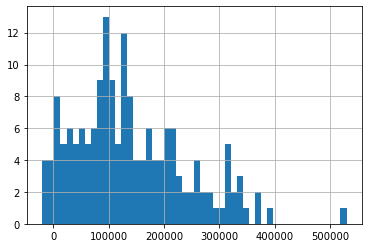

In [285]:
# quick histogram to visualize potential skewness
df19['delta_price'].hist(bins=50);

In [286]:
# freezing price mean and std
rvs_delta_price = stats.norm(loc=df19['delta_price'].mean(), scale=df19['delta_price'].std())

In [287]:
# calculating interquartile range for price
IQR_delta_price = rvs_delta_price.ppf(0.75) - rvs_delta_price.ppf(0.25)
IQR_delta_price

135566.31143031316

In [288]:
# calculating outliers via IQR range
upper_delta_price = rvs_delta_price.ppf(0.75) + (1.5*IQR_delta_price)
upper_delta_price

409950.7573635503

In [289]:
lower_delta_price = rvs_delta_price.ppf(0.25) - (1.5*IQR_delta_price)
lower_delta_price

-132314.48835770233

In [290]:
# df20 - creating a dataframe with price values above the upper_price 
# threshold removed
df20 = df19.drop(df19[(df19['delta_price'] >= upper_delta_price) | (df19['delta_price'] <= lower_delta_price)].index)

In [291]:
# checking size of new datafram
df20.shape

(170, 16)

In [292]:
len(df19) - len(df20)

1

In [293]:
(len(df19) - len(df20)) / len(df19)

0.005847953216374269

- So we removed 0.58% of data points based on high change in price outliers

# NOW onto Modeling our data

For our baseline model, we will look at the ratio of the average price to the average of each feature of our dataset.  We will use df8 for our starting point.

We'll remove numeric values of "id" (meaningless numeric for model) and "price" since that will be our target

In [294]:
df8drop = df8.drop(['id', 'price'], axis=1)

In [295]:
for column in df8drop.columns:
    bm = df8['price'].mean() / df8drop[column].mean()
    print(column, bm)

bedrooms 160239.2867167438
bathrooms 255359.61085883732
sqft_living 259.7177804188506
sqft_lot 35.78263110008999
floors 361620.95878269494
sqft_above 302.078456570963
yr_built 274.12311636434026
sqft_living15 271.9677075226526
sqft_lot15 42.34868844342455
time_stamp 0.0003819506325702615
dist_Seattle 46985.54092696505
ord_cond 224205.68926890192


This is a baseline model to predict the price based on a change in each feature. Please see below for definition of df8drop.

## Creating a multiple linear regression model (Model 0) based on highest correlations to price using dataframe that did NOT have sqft_lot15 or price outliers removed yet (df8)

In [296]:
# check shape
df8.shape

(21597, 14)

In [297]:
# confirm correct columns are there
df8.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond
0,7129300520,221900.0,3,1.00,1180,5650,1.0,1180,1955,1340,5650,1.413173e+09,7.418041,2.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,2170,1951,1690,7639,1.418101e+09,8.046810,2.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,770,1933,2720,8062,1.424840e+09,10.323554,2.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,1050,1965,1360,5000,1.418101e+09,6.427255,4.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,1680,1987,1800,7503,1.424236e+09,13.504920,2.0


In [298]:
# scaling for model
ss_df8 = StandardScaler().fit(df8drop)
df8_scaled = ss_df8.transform(df8drop)

In [299]:
# creating a dataframe for scaled data to retain column names later 
# in model summary
df8_scaled = pd.DataFrame(df8_scaled, columns=df8drop.columns)

In [300]:
# establishing endog & exog
x0 = sm.add_constant(df8_scaled)
y0 = df8['price'].reset_index(drop=True)

In [301]:
# fitting our model
model0 = sm.OLS(endog=y0, exog=x0).fit()

In [302]:
# displaying model summary
model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     3363.
Date:                Fri, 28 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:23:19   Log-Likelihood:            -2.9601e+05
No. Observations:               21597   AIC:                         5.920e+05
Df Residuals:                   21584   BIC:                         5.921e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.403e+05   1476.049    366.043      0.000    5.37e+05    5.43e+05
bedrooms       -5.49e+04   1892.506    -29.007      0.000   -5.86e+04   -5.12e+04
bathrooms      4.294e+04   2679.775     16.023      0.000    3.77e+04    4.82e+04
sqft_living    1.806e+05   4209.955     42.902      0.000    1.72e+05    1.89e+05
sqft_lot       1.274e+04   2137.783      5.959      0.000    8548.528    1.69e+04
floors        -4222.8652   2101.709     -2.009      0.045   -8342.369    -103.361
sqft_above     5.838e+04   3814.646     15.305      0.000    5.09e+04    6.59e+04
yr_built      -3.835e+04   2141.605    -17.906      0.000   -4.25e+04   -3.41e+04
sqft_living15  6.502e+04   2348.636     27.682      0.000    6.04e+04    6.96e+04
sqft_lot15     -928.6516   2161.273     -0.430      0.667   -5164.906    3307.603
time_stamp     1.227e+04   1480.065      8.287      0.000    9364.521    1.52e+04
dist_Seattle  -1.247e+05   1787.021    -69.769      0.000   -1.28e+05   -1.21e+05
ord_cond        2.26e+04   1616.586     13.980      0.000    1.94e+04    2.58e+04
==============================================================================
Omnibus:                    17883.052   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1336079.612
Skew:                           3.517   Prob(JB):                         0.00
Kurtosis:                      40.885   Cond. No.                         7.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We note an adjusted R^2 of 0.651, probability of F-statistic = 0.000, and the p-values of all the features except "sqft_lot15" are significant at an alpha of 0.05.  So we will refine our model, remove outliers from "sqft_lot15", and recheck.

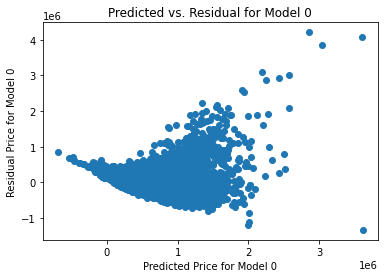

In [303]:
# predicted price vs. residual price for Model 0, based on df8
preds0 = model0.predict(x0)
resids0 = y0 - preds0

plt.plot(preds0, resids0, "o")
plt.xlabel('Predicted Price for Model 0')
plt.ylabel('Residual Price for Model 0')
plt.title('Predicted vs. Residual for Model 0');

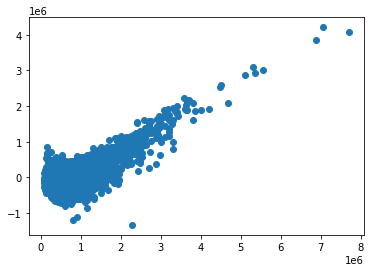

In [304]:
# checking for independence and homoskedasticity
fig, ax = plt.subplots()
ax.scatter(y0, resids0);

Scatterplot appears linear, indicating independence, and the tight distribution of higher y values indicates our data is homoskedastic

In [305]:
# exploring Durbin-Watson score
model0.summary().tables[2]

Omnibus:,17883.052,Durbin-Watson:,2.001
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1336079.612
Skew:,3.517,Prob(JB):,0.00
Kurtosis:,40.885,Cond. No.,7.61


This Durbin-Watson score of 2.001 indicates adequate independence of features.

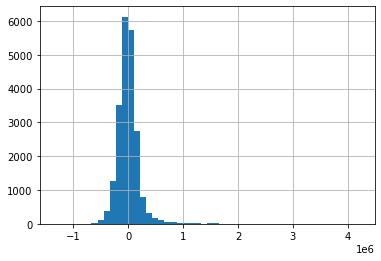

In [306]:
# creating histogram of residuals (errors)

resids0.hist(bins=50);

This histogram has tight distribution of errors and indicates our data is normal

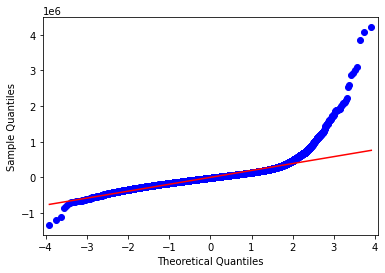

In [307]:
# Creating QQ plot  
sm.qqplot(resids0, line='r');

QQ plot is another means for assessing for normality of errors.  We note the errors follow the line closely until the end 

In [308]:
# viewing summary table of model0
model0.summary().tables[2]

Omnibus:,17883.052,Durbin-Watson:,2.001
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1336079.612
Skew:,3.517,Prob(JB):,0.00
Kurtosis:,40.885,Cond. No.,7.61


We want a smaller Jarque-Bera (currently 1.3 million), and prob(JB) > 0.05.  We also want a small Omnibus number (currently 17,883), as well as Skew (3.517) & Kurtosis (40.885).  Condition number already appears in a safe range (<1,000), and therefore we do not appear to have a significant amount of multicollinearity between the features.

## Summary of Model 0
The model met all the assumptions for multiple linear regression, but not all p-values were significant and our summaries indicate high Omnibus, Jarque-Bera, Skew & Kurtosis values.  

## Creating a model (Model 1) based on highest correlations to price with dataframe with all prices included BUT sqft_lot15 outliers removed (df9)

In [309]:
# check shape of df9 again
df9.shape

(21190, 14)

In [310]:
# review df9 columns, making they're all there
df9.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond
0,7129300520,221900.0,3,1.00,1180,5650,1.0,1180,1955,1340,5650,1.413173e+09,7.418041,2.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,2170,1951,1690,7639,1.418101e+09,8.046810,2.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,770,1933,2720,8062,1.424840e+09,10.323554,2.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,1050,1965,1360,5000,1.418101e+09,6.427255,4.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,1680,1987,1800,7503,1.424236e+09,13.504920,2.0


In [311]:
# we'll remove numeric values of "id" (meaningless numeric for model) and 
# "price" since that will be our target
df9drop = df9.drop(['id', 'price'], axis=1)

In [312]:
# scaling for model
ss_df9 = StandardScaler().fit(df9drop)
df9_scaled = ss_df9.transform(df9drop)

In [313]:
# creating a dataframe for scaled data to retain column names later 
# in model summary
df9_scaled = pd.DataFrame(df9_scaled, columns=df9drop.columns)

In [314]:
# establishing endog & exog
x1 = sm.add_constant(df9_scaled)
y1 = df9['price'].reset_index(drop=True)

In [315]:
# fitting our model
model1 = sm.OLS(endog=y1, exog=x1).fit()

In [316]:
# displaying model 1 summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     3309.
Date:                Fri, 28 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:23:20   Log-Likelihood:            -2.9042e+05
No. Observations:               21190   AIC:                         5.809e+05
Df Residuals:                   21177   BIC:                         5.810e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.387e+05   1489.745    361.610      0.000    5.36e+05    5.42e+05
bedrooms      -5.604e+04   1914.269    -29.276      0.000   -5.98e+04   -5.23e+04
bathrooms      4.304e+04   2696.921     15.958      0.000    3.78e+04    4.83e+04
sqft_living    1.837e+05   4222.320     43.496      0.000    1.75e+05    1.92e+05
sqft_lot       4104.4283   1777.888      2.309      0.021     619.633    7589.223
floors        -2659.8954   2146.923     -1.239      0.215   -6868.027    1548.236
sqft_above     5.523e+04   3831.309     14.415      0.000    4.77e+04    6.27e+04
yr_built      -3.845e+04   2166.641    -17.748      0.000   -4.27e+04   -3.42e+04
sqft_living15  6.111e+04   2402.861     25.431      0.000    5.64e+04    6.58e+04
sqft_lot15     9621.4577   1937.781      4.965      0.000    5823.260    1.34e+04
time_stamp     1.235e+04   1494.098      8.266      0.000    9422.201    1.53e+04
dist_Seattle   -1.25e+05   1813.970    -68.890      0.000   -1.29e+05   -1.21e+05
ord_cond       2.232e+04   1633.302     13.666      0.000    1.91e+04    2.55e+04
==============================================================================
Omnibus:                    17379.730   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1252513.270
Skew:                           3.474   Prob(JB):                         0.00
Kurtosis:                      40.018   Cond. No.                         7.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We note an adjusted R^2 of 0.652, probability of F-statistic = 0.000, and the p-values of all the features except "floors" are significant at an alpha of 0.05. So we will refine our model again, proceed with removing outliers for "price", and recheck.

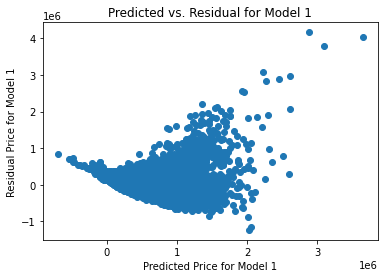

In [317]:
# predicted vs. residual
preds1 = model1.predict(x1)
resids1 = y1 - preds1

plt.plot(preds1, resids1, "o")
plt.xlabel('Predicted Price for Model 1')
plt.ylabel('Residual Price for Model 1')
plt.title('Predicted vs. Residual for Model 1');

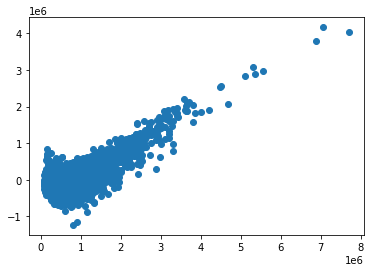

In [318]:
# checking for independence and homoskedasticity
fig, ax = plt.subplots()
ax.scatter(y1, resids1);

Scatterplot appears linear, indicating independence, and the tight distribution of higher y values indicates our data is homoskedastic


In [319]:
# displaying Durbin-Watson
model1.summary().tables[2]

Omnibus:,17379.730,Durbin-Watson:,2.003
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1252513.270
Skew:,3.474,Prob(JB):,0.00
Kurtosis:,40.018,Cond. No.,7.58


This Durbin-Watson score of 2.003 again indicates adequate independence of features.

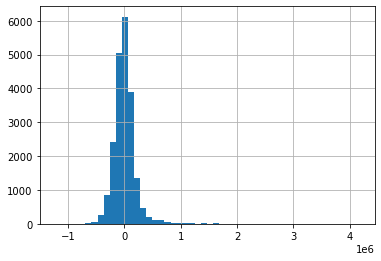

In [320]:
# creating histogram of residuals (errors) 

resids1.hist(bins=50);

This histogram has tight distribution of errors and indicates our data is normal

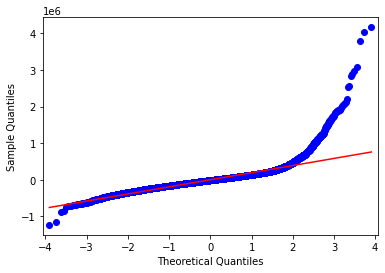

In [321]:
# Creating QQ plot 
sm.qqplot(resids1, line='r');

QQ plot is another means for assessing for normality of errors.  We note the errors follow the line closely until the end 

In [322]:
# displaying model 1 summary
model1.summary().tables[2]

Omnibus:,17379.730,Durbin-Watson:,2.003
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1252513.270
Skew:,3.474,Prob(JB):,0.00
Kurtosis:,40.018,Cond. No.,7.58


We want a smaller Jarque-Bera (currently 1.25 million), and prob(JB) > 0.05.  We also want a small Omnibus number (currently 17,380), as well as Skew (3.474) & Kurtosis (40.018).  Condition number already appears in a safe range (<1,000), and therefore we do not appear to have a significant amount of multicollinearity between the features.

## Summary of Model 1
The model met all the assumptions for multiple linear regression, but not all p-values were significant and our summaries indicate high Omnibus, Jarque-Bera, Skew & Kurtosis values.  

## Creating a model (Model 2) from the lower price dataframe (df10)

### We'll call this our "Final Model" though we will spend additional time exploring resale information too, out of curiousity. 

In [323]:
# checking shape
df10.shape

(20706, 14)

In [324]:
# reviewing column names
df10.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,time_stamp,dist_Seattle,ord_cond
0,7129300520,221900.0,3,1.00,1180,5650,1.0,1180,1955,1340,5650,1.413173e+09,7.418041,2.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,2170,1951,1690,7639,1.418101e+09,8.046810,2.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,770,1933,2720,8062,1.424840e+09,10.323554,2.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,1050,1965,1360,5000,1.418101e+09,6.427255,4.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,1680,1987,1800,7503,1.424236e+09,13.504920,2.0


In [325]:
# we'll again remove numeric values of "id" (meaningless numeric for model) and 
# "price" since that will be our target
df10drop = df10.drop(['id', 'price'], axis=1)

In [326]:
# scaling for model
ss_df10 = StandardScaler().fit(df10drop)
df10_scaled = ss_df10.transform(df10drop)

In [327]:
# creating a dataframe for scaled data to retain column names later 
# in model summary
df10_scaled = pd.DataFrame(df10_scaled, columns=df10drop.columns)

In [328]:
# establishing endog & exog
x2 = sm.add_constant(df10_scaled)
y2 = df10['price'].reset_index(drop=True)

In [329]:
# fitting model
model2 = sm.OLS(endog=y2, exog=x2).fit()

In [330]:
# displaying model 2 summary
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     3362.
Date:                Fri, 28 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:23:22   Log-Likelihood:            -2.7553e+05
No. Observations:               20706   AIC:                         5.511e+05
Df Residuals:                   20693   BIC:                         5.512e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.009e+05   1011.174    495.326      0.000    4.99e+05    5.03e+05
bedrooms      -2.566e+04   1311.452    -19.565      0.000   -2.82e+04   -2.31e+04
bathrooms      2.849e+04   1773.811     16.063      0.000     2.5e+04     3.2e+04
sqft_living    9.376e+04   2725.026     34.408      0.000    8.84e+04    9.91e+04
sqft_lot       7670.4402   1202.612      6.378      0.000    5313.225       1e+04
floors         1.154e+04   1475.058      7.823      0.000    8647.651    1.44e+04
sqft_above     3.127e+04   2510.231     12.458      0.000    2.64e+04    3.62e+04
yr_built      -2.544e+04   1484.375    -17.141      0.000   -2.84e+04   -2.25e+04
sqft_living15  7.123e+04   1627.981     43.751      0.000     6.8e+04    7.44e+04
sqft_lot15     8397.7112   1308.709      6.417      0.000    5832.539     1.1e+04
time_stamp     8639.3306   1014.388      8.517      0.000    6651.051    1.06e+04
dist_Seattle  -1.059e+05   1238.337    -85.551      0.000   -1.08e+05   -1.04e+05
ord_cond        2.04e+04   1107.012     18.425      0.000    1.82e+04    2.26e+04
==============================================================================
Omnibus:                     3112.488   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7792.525
Skew:                           0.849   Prob(JB):                         0.00
Kurtosis:                       5.480   Cond. No.                         7.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We note an adjusted R^2 of 0.661, probability of F-statistic = 0.000, and the p-values of all the features are now **ALL** significant at an alpha of 0.05.

## Checking assumptions

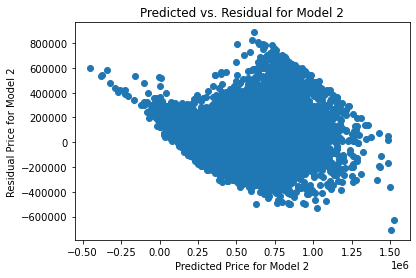

In [331]:
# predicted vs. residual
preds2 = model2.predict(x2)
resids2 = y2 - preds2

plt.plot(preds2, resids2, "o")
plt.xlabel('Predicted Price for Model 2')
plt.ylabel('Residual Price for Model 2')
plt.title('Predicted vs. Residual for Model 2');

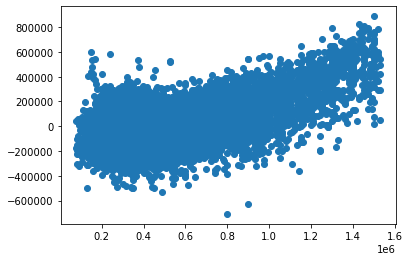

In [332]:
# checking for independence and homoskedasticity
fig, ax = plt.subplots()
ax.scatter(y2, resids2);

Scatterplot appears linear, indicating independence, and the tight distribution of higher y values indicates our data is homoskedastic


In [333]:
# reviewing model summary for Durbin-Watson
model2.summary().tables[2]

Omnibus:,3112.488,Durbin-Watson:,2.011
Prob(Omnibus):,0.000,Jarque-Bera (JB):,7792.525
Skew:,0.849,Prob(JB):,0.00
Kurtosis:,5.480,Cond. No.,7.23


This Durbin-Watson score of 2.011 indicates adequate independence of features.

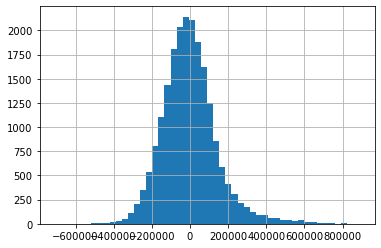

In [334]:
# creating histogram of residuals (errors)

resids2.hist(bins=50);

This histogram has tight distribution of errors and indicates our data is normal

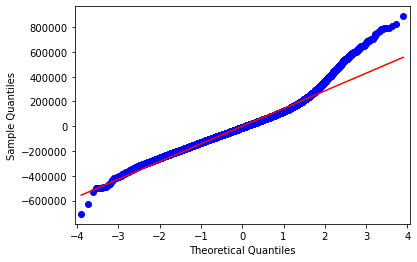

In [335]:
# Creating QQ plot 
sm.qqplot(resids2, line='r');

We note in this QQ plot that the errors follow the line the closest out of all our models.

In [336]:
# Reviewing model 2 summary again
model2.summary().tables[2]

Omnibus:,3112.488,Durbin-Watson:,2.011
Prob(Omnibus):,0.000,Jarque-Bera (JB):,7792.525
Skew:,0.849,Prob(JB):,0.00
Kurtosis:,5.480,Cond. No.,7.23


Our Jarque-Bera is way down (now 7792.5), though prob(JB) is still > 0.05.  Our Omnibus number (3,112), Skew (0.849) and Kurtosis (5.480) are much improved.  Condition number remains in a safe range (<1,000), and therefore we do not appear to have a significant amount of multicollinearity between the features.
This is our best model so far, satsifies all our assumptions, and will be the basis of our conclusions presented.

## For a recap and comparison to the prior models, please see below

In [337]:
print(model0.summary().tables[2], model1.summary().tables[2], model2.summary().tables[2])

Omnibus:                    17883.052   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1336079.612
Skew:                           3.517   Prob(JB):                         0.00
Kurtosis:                      40.885   Cond. No.                         7.61
============================================================================== ==============================================================================
Omnibus:                    17379.730   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1252513.270
Skew:                           3.474   Prob(JB):                         0.00
Kurtosis:                      40.018   Cond. No.                         7.58
============================================================================== ==============================================================================
Omnibus:                     3112.488   Durbin-Watso

# Resale Model

We will use the data culled from refining the dataset above to look at potential inferences we can draw from our resale data.  

## Creating model based on highest correlations to change in price from dataframe of houses that were resold

Below we will remove our target ("delta_price") as well as other numerics that may interfere

In [338]:
# creating df19drop
df19drop = df19.drop(['price', 'sale_count', 'dup', 'delta_price'], axis=1)

In [339]:
# scaling for model
ss_df19 = StandardScaler().fit(df19drop)
df19_scaled = ss_df19.transform(df19drop)

In [340]:
# creating a dataframe for scaled data to retain column names later 
# in model summary
df19_scaled = pd.DataFrame(df19_scaled, columns=df19drop.columns)

In [341]:
# establishing endog & exog
x3 = sm.add_constant(df19_scaled)
y3 = df19['delta_price'].reset_index(drop=True)

In [342]:
# fitting model
model3 = sm.OLS(endog=y3, exog=x3).fit()

In [343]:
# displaying summary of model
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            delta_price   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     4.241
Date:                Fri, 28 Oct 2022   Prob (F-statistic):           8.54e-06
Time:                        18:23:23   Log-Likelihood:                -2187.8
No. Observations:                 171   AIC:                             4402.
Df Residuals:                     158   BIC:                             4442.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.388e+05   6932.760     20.024      0.000    1.25e+05    1.53e+05
bedrooms       8572.9999   8870.976      0.966      0.335   -8947.994    2.61e+04
bathrooms      1011.2343   1.21e+04      0.084      0.933   -2.28e+04    2.48e+04
sqft_living    2.246e+04   1.75e+04      1.284      0.201   -1.21e+04     5.7e+04
sqft_lot       9604.6643   1.32e+04      0.730      0.466   -1.64e+04    3.56e+04
floors        -3751.4420   1.07e+04     -0.349      0.727    -2.5e+04    1.75e+04
sqft_above    -1.238e+04   1.52e+04     -0.812      0.418   -4.25e+04    1.77e+04
yr_built      -2.727e+04   1.02e+04     -2.670      0.008   -4.74e+04   -7095.060
sqft_living15 -5495.5901   1.13e+04     -0.488      0.626   -2.77e+04    1.67e+04
sqft_lot15    -1.711e+04   1.34e+04     -1.281      0.202   -4.35e+04    9273.715
time_stamp     8857.2734   7313.255      1.211      0.228   -5587.079    2.33e+04
dist_Seattle  -2.063e+04   8780.806     -2.349      0.020    -3.8e+04   -3283.813
ord_cond      -4048.1492   7099.382     -0.570      0.569   -1.81e+04    9973.783
==============================================================================
Omnibus:                       11.274   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               14.856
Skew:                           0.426   Prob(JB):                     0.000594
Kurtosis:                       4.165   Cond. No.                         6.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We note an adjusted R^2 of only 0.186, but a very small probability of F-statistic.  Unfortunately, the p-values of most features are *not* significant at an alpha of 0.05.  However, distance to Downtown Seattle ("dist_Seattle") remains significant, and we see "yr_built" is significant as well.  We'll look into the effect of removing "delta_price" outliers in a model (Model 4) below.

## Checking assumptions

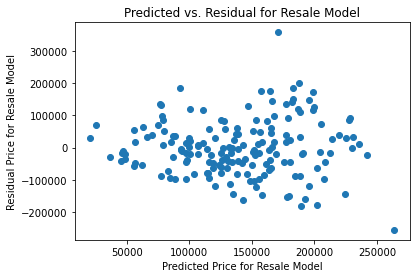

In [344]:
# predicted vs. residual
preds3 = model3.predict(x3)
resids3 = y3 - preds3

plt.plot(preds3, resids3, "o")
plt.xlabel('Predicted Price for Resale Model')
plt.ylabel('Residual Price for Resale Model')
plt.title('Predicted vs. Residual for Resale Model');

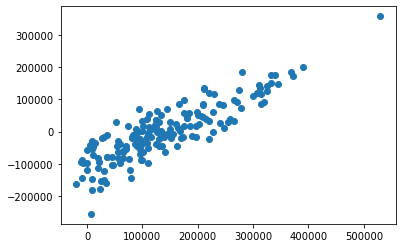

In [345]:
# checking for independence and homoskedasticity
fig, ax = plt.subplots()
ax.scatter(y3, resids3);

Scatterplot appears linear, indicating independence, and the tight distribution of higher y values indicates our data is homoskedastic


In [346]:
# looking at Durbin-Watson score
model3.summary().tables[2]

Omnibus:,11.274,Durbin-Watson:,1.918
Prob(Omnibus):,0.004,Jarque-Bera (JB):,14.856
Skew:,0.426,Prob(JB):,0.000594
Kurtosis:,4.165,Cond. No.,6.53


This Durbin-Watson score of 1.918 indicates adequate independence of features.

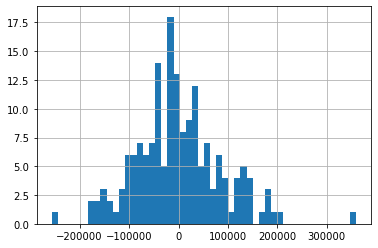

In [347]:
# creating histogram of residuals (errors)

resids3.hist(bins=50);

This histogram looks relatively normally-distributed, but it looks like we have a few outliers.

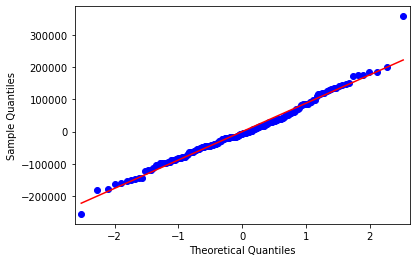

In [348]:
# Creating QQ plot 
sm.qqplot(resids3, line='r');

QQ plot is another means for assessing for normality of errors.  We note the errors follow the line closely

In [349]:
# Reviewing summary table
model3.summary().tables[2]

Omnibus:,11.274,Durbin-Watson:,1.918
Prob(Omnibus):,0.004,Jarque-Bera (JB):,14.856
Skew:,0.426,Prob(JB):,0.000594
Kurtosis:,4.165,Cond. No.,6.53


Jarque-Bera (14.856) is a low number, though Prob(JB) is still <0.05.  Omnibus (11.274), Skew (0.426), and Kurtosis (4.165) are all low, as is the Condition number (6.53).  

## Recreating Resale Model with high change in price outliers removed

In [350]:
# same drops as above
df20drop = df20.drop(['price', 'sale_count', 'dup', 'delta_price'], axis=1)

In [351]:
# scaling for model
ss_df20 = StandardScaler().fit(df20drop)
df20_scaled = ss_df20.transform(df20drop)

In [352]:
# creating a dataframe for scaled data to retain column names later 
# in model summary
df20_scaled = pd.DataFrame(df20_scaled, columns=df20drop.columns)

In [353]:
# establishing endog & exog
x4 = sm.add_constant(df20_scaled)
y4 = df20['delta_price'].reset_index(drop=True)

In [354]:
# fitting model
model4 = sm.OLS(endog=y4, exog=x4).fit()

In [355]:
# displaying summary of model
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            delta_price   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     4.465
Date:                Fri, 28 Oct 2022   Prob (F-statistic):           3.79e-06
Time:                        18:23:25   Log-Likelihood:                -2166.3
No. Observations:                 170   AIC:                             4359.
Df Residuals:                     157   BIC:                             4399.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.365e+05   6607.716     20.660      0.000    1.23e+05     1.5e+05
bedrooms       1.109e+04   8438.376      1.314      0.191   -5580.594    2.78e+04
bathrooms      2698.3681   1.15e+04      0.235      0.814   -1.99e+04    2.53e+04
sqft_living    2.356e+04   1.66e+04      1.416      0.159   -9300.215    5.64e+04
sqft_lot       1.159e+04   1.25e+04      0.926      0.356   -1.31e+04    3.63e+04
floors        -1357.1252   1.02e+04     -0.132      0.895   -2.16e+04    1.89e+04
sqft_above    -1.587e+04   1.45e+04     -1.092      0.277   -4.46e+04    1.28e+04
yr_built      -2.769e+04   9719.247     -2.848      0.005   -4.69e+04   -8487.692
sqft_living15 -6272.0216   1.07e+04     -0.585      0.560   -2.75e+04    1.49e+04
sqft_lot15    -1.713e+04   1.27e+04     -1.348      0.180   -4.22e+04    7977.546
time_stamp     7004.4131   6974.319      1.004      0.317   -6771.187    2.08e+04
dist_Seattle  -1.867e+04   8364.453     -2.232      0.027   -3.52e+04   -2148.052
ord_cond      -3127.5314   6766.759     -0.462      0.645   -1.65e+04    1.02e+04
==============================================================================
Omnibus:                        0.842   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.657   Jarque-Bera (JB):                0.577
Skew:                           0.130   Prob(JB):                        0.749
Kurtosis:                       3.119   Cond. No.                         6.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We note a slight increase in adjusted R^2 value (0.197 from 0.186) meaning we increased the ability of our model to explain the variation in change in price.  However, the only significant p-values at an alpha of 0.05 are distance to downtown Seattle ("dist_Seattle") and "yr_built".

## Checking assumptions

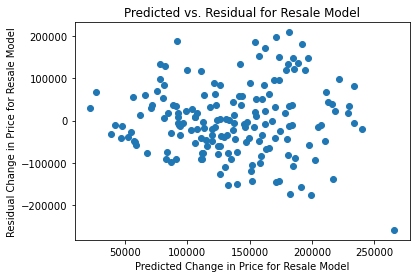

In [356]:
# predicted vs. residual
preds4 = model4.predict(x4)
resids4 = y4 - preds4

plt.plot(preds4, resids4, "o")
plt.xlabel('Predicted Change in Price for Resale Model')
plt.ylabel('Residual Change in Price for Resale Model')
plt.title('Predicted vs. Residual for Resale Model');

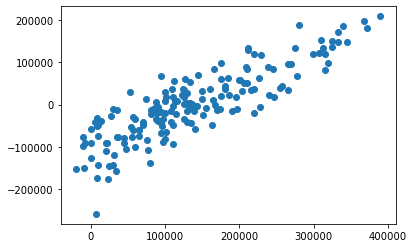

In [357]:
# checking for independence and homoskedasticity
fig, ax = plt.subplots()
ax.scatter(y4, resids4);

Scatterplot appears linear, indicating independence, and the tight distribution of higher y values indicates our data is homoskedastic

In [358]:
# looking at Durbin-Watson 
model4.summary().tables[2]

Omnibus:,0.842,Durbin-Watson:,1.977
Prob(Omnibus):,0.657,Jarque-Bera (JB):,0.577
Skew:,0.130,Prob(JB):,0.749
Kurtosis:,3.119,Cond. No.,6.51


This Durbin-Watson score of 1.977 indicates adequate independence of features.

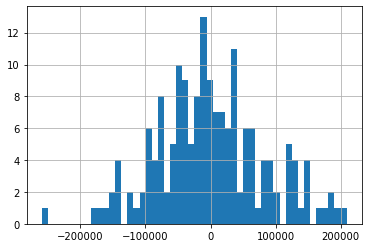

In [359]:
# creating histogram of residuals (errors)

resids4.hist(bins=50);

This histogram looks relatively normally-distributed, but it looks like we have a few outliers.

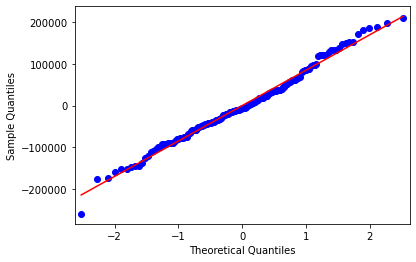

In [360]:
# Creating QQ plot
sm.qqplot(resids4, line='r');

In this QQ plot, we note the errors follow the line closely

In [361]:
# Displaying model summary 
model4.summary().tables[2]

Omnibus:,0.842,Durbin-Watson:,1.977
Prob(Omnibus):,0.657,Jarque-Bera (JB):,0.577
Skew:,0.130,Prob(JB):,0.749
Kurtosis:,3.119,Cond. No.,6.51


Jarque-Bera (0.577) is a very low number, and now Prob(JB) is >0.05.  Omnibus (0.842), Skew (0.130), and Kurtosis (3.119) are all low, as is the Condition number (6.51).  

## For a recap and comparison to the prior models, please see below

In [362]:
print(model3.summary().tables[2], model4.summary().tables[2])

Omnibus:                       11.274   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               14.856
Skew:                           0.426   Prob(JB):                     0.000594
Kurtosis:                       4.165   Cond. No.                         6.53
============================================================================== ==============================================================================
Omnibus:                        0.842   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.657   Jarque-Bera (JB):                0.577
Skew:                           0.130   Prob(JB):                        0.749
Kurtosis:                       3.119   Cond. No.                         6.51


# Evaluations

For our Model 2 (final model) we obtained an adjusted R-squared value of 0.661, which means our model can explain 66% of the variation in sale price.  This model has a p-value (prob of F-stat) of <0.05 which means we can reject the null hypothesis that there is no relationship between our predictors and the target ("price") and that our model is better at predicting sales price than our baseline model.  

Our Model 2 (final model) also passed all assumptions for LINH and multicollinearity.

## Actual vs. Predicted of Model 2 (final model)

This plot depicts how well the actual sale prices compare to our model-predicted sale prices.  As you can see, our model-predicted values closely mirror the actual price values creating a best-fit line that follows along with y = x.  

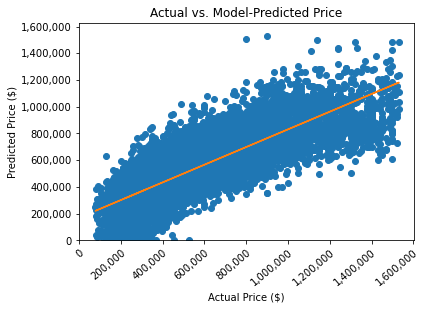

In [363]:
# predicted vs. actual
model2_pred = model2.predict(x2)


y_ap_2 = model2_pred
x_ap_2 = df10['price']

plt.plot(x_ap_2,y_ap_2, "o")
m, b = np.polyfit(x_ap_2, y_ap_2, 1)
plt.plot(x_ap_2, m*x_ap_2+b)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.xlabel('Actual Price ($)')
plt.xticks(rotation=40, ha="right", rotation_mode='anchor')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('Predicted Price ($)')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Actual vs. Model-Predicted Price')
plt.savefig('./images/model_act_pred', bbox_inches='tight', dpi=300);

## Actual vs Predicted for Resale Model

For Model 4 (resale model), we obtained an adjusted R-squared value of 0.197, which means our model can only explain about 20% of the variation in change of *resale* price.  This model has a p-value (prob of F-stat) of <0.05 which means we can reject the null hypothesis that there is no relationship between our predictors and the target ("delta_price") and that our model is better at predicting sales price than our baseline model.  

Our Model 4 (resale model) also passed all assumptions for LINH and multicollinearity.

However, we have many features that are not significant for the model.

This plot depicts how well the actual change in *resale* price compare to our model-predicted change in *resale* price.  As you can see, our model-predicted values do not mirror the actual price values as closely as previous model, but follow a similar trend.    

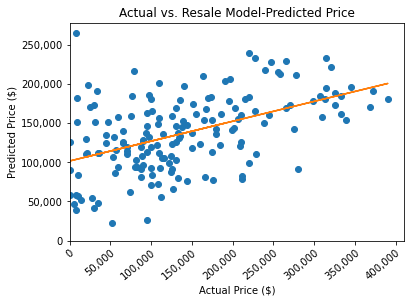

In [364]:
# predicted vs. actual
model4_pred = model4.predict(x4)


y_ap_4 = model4_pred
x_ap_4 = df20['delta_price']

plt.plot(x_ap_4,y_ap_4, "o")
m, b = np.polyfit(x_ap_4, y_ap_4, 1)
plt.plot(x_ap_4, m*x_ap_4+b)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.xlabel('Actual Price ($)')
plt.xticks(rotation=40, ha="right", rotation_mode='anchor')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('Predicted Price ($)')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Actual vs. Resale Model-Predicted Price')
plt.savefig('./images/resale_model_act_pred', bbox_inches='tight', dpi=300);

# Conclusions

## Bar plot

Below is a visual of the absolute values of the coefficients from model 2 (scaled), highlighting the three features with the highest coefficients and therefore the greatest impact on sale price.

In [365]:
# defining x-axis values
x_bar = model2.params.map(abs).sort_values(ascending=False).index[1:13]
print(x_bar)

Index(['dist_Seattle', 'sqft_living', 'sqft_living15', 'sqft_above',
       'bathrooms', 'bedrooms', 'yr_built', 'ord_cond', 'floors', 'time_stamp',
       'sqft_lot15', 'sqft_lot'],
      dtype='object')


In [366]:
# defining y axis values
y_bar= model2.params.map(abs).sort_values(ascending=False)[1:13]
print(y_bar)

dist_Seattle     105941.120889
sqft_living       93763.442475
sqft_living15     71225.923895
sqft_above        31272.243970
bathrooms         28492.048986
bedrooms          25658.076063
yr_built          25444.271392
ord_cond          20397.088474
floors            11538.881107
time_stamp         8639.330580
sqft_lot15         8397.711213
sqft_lot           7670.440235
dtype: float64


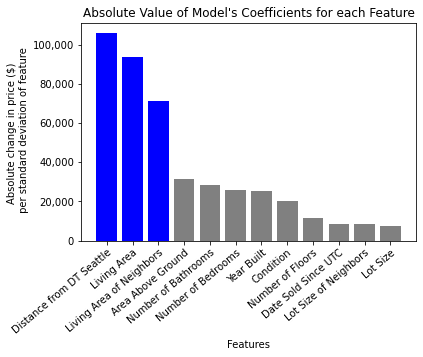

In [367]:
features_list = ['Distance from DT Seattle', 'Living Area', 'Living Area of Neighbors', 'Area Above Ground', 'Number of Bathrooms', 'Number of Bedrooms', 'Year Built', 'Condition', 'Number of Floors', 'Date Sold Since UTC', 'Lot Size of Neighbors', 'Lot Size']
plt.bar(x = features_list, height = y_bar, color=['blue', 'blue', 'blue', 'grey', 'grey','grey','grey','grey','grey','grey','grey','grey'])
plt.xticks(rotation=40, ha="right", rotation_mode='anchor')
plt.xlabel('Features')
plt.ylabel('Absolute change in price ($) \n per standard deviation of feature')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title("Absolute Value of Model's Coefficients for each Feature")
plt.savefig('./images/coefs', bbox_inches='tight', dpi=300);

## Scatter Plots

### House Price as a function of Area of Living Space

Creating "unscaled" dataframe of final model (df10) to illustrate the effect of each individual feature on our target of sale price

In [368]:
# dropping id and price again
df10drop = df10.drop(['id', 'price'], axis=1)

In [369]:
# endog and exog
x2_unscaled = sm.add_constant(df10drop)
y2_unscaled = df10['price']

In [370]:
# fitting model
model2_unscaled = sm.OLS(endog=y2_unscaled, exog=x2_unscaled).fit()

In [371]:
# model12_unscaled summary
model2_unscaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     3362.
Date:                Fri, 28 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:23:28   Log-Likelihood:            -2.7553e+05
No. Observations:               20706   AIC:                         5.511e+05
Df Residuals:                   20693   BIC:                         5.512e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.191e+05   1.77e+05      2.934      0.003    1.72e+05    8.66e+05
bedrooms      -2.866e+04   1464.633    -19.565      0.000   -3.15e+04   -2.58e+04
bathrooms      3.901e+04   2428.720     16.063      0.000    3.43e+04    4.38e+04
sqft_living     114.7572      3.335     34.408      0.000     108.220     121.294
sqft_lot          0.3025      0.047      6.378      0.000       0.210       0.395
floors         2.142e+04   2737.574      7.823      0.000     1.6e+04    2.68e+04
sqft_above       41.4352      3.326     12.458      0.000      34.916      47.954
yr_built       -866.1211     50.528    -17.141      0.000    -965.160    -767.082
sqft_living15   110.3006      2.521     43.751      0.000     105.359     115.242
sqft_lot15        0.8930      0.139      6.417      0.000       0.620       1.166
time_stamp        0.0009      0.000      8.517      0.000       0.001       0.001
dist_Seattle  -1.627e+04    190.190    -85.551      0.000   -1.66e+04   -1.59e+04
ord_cond       3.142e+04   1705.253     18.425      0.000    2.81e+04    3.48e+04
==============================================================================
Omnibus:                     3112.488   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7792.525
Skew:                           0.849   Prob(JB):                         0.00
Kurtosis:                       5.480   Cond. No.                     2.48e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.48e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All of the above information matches the Model 2 (scaled) summary

In [372]:
# reviewing unscaled coefficient values
model2_unscaled.params

const            519135.222956
bedrooms         -28655.005947
bathrooms         39011.587805
sqft_living         114.757220
sqft_lot              0.302457
floors            21415.107229
sqft_above           41.435234
yr_built           -866.121109
sqft_living15       110.300564
sqft_lot15            0.893013
time_stamp            0.000886
dist_Seattle     -16270.993230
ord_cond          31419.879643
dtype: float64

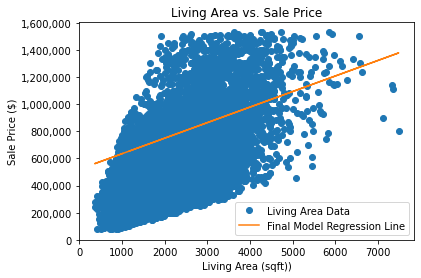

In [373]:
x = df10drop['sqft_living']
y = y2 
plt.plot(x, y, 'o', alpha=1)
m = model2_unscaled.params[3]
b = model2_unscaled.params[0]
plt.plot(x, m*x+b)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.xlabel('Living Area (sqft))')
plt.ylabel('Sale Price ($)')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Living Area vs. Sale Price')
plt.legend(['Living Area Data', 'Final Model Regression Line'])
plt.savefig('./images/sqftscatter', bbox_inches='tight', dpi=300);

## House Price as a Function of Distance from Downtown Seattle

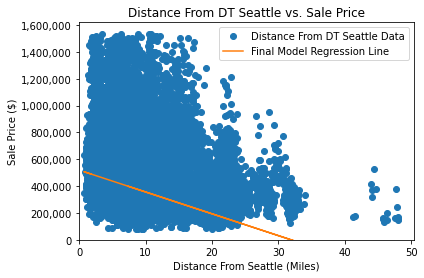

In [374]:
x = df10drop['dist_Seattle']
y = y2
plt.plot(x, y, 'o', alpha=1)
m = model2_unscaled.params[11]
b = model2_unscaled.params[0]
plt.plot(x, m*x+b)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.xlabel('Distance From Seattle (Miles)')
plt.ylabel('Sale Price ($)')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Distance From DT Seattle vs. Sale Price')
plt.legend(['Distance From DT Seattle Data', 'Final Model Regression Line'])
plt.savefig('./images/dist_scatter', bbox_inches='tight', dpi=300);

## House Price as a Function of Living Space for Closest 15 Neighbors

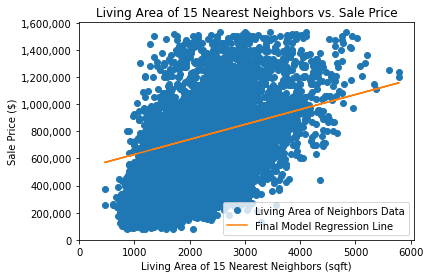

In [375]:
x = df10drop['sqft_living15']
y = y2
plt.plot(x, y, 'o', alpha=1)
m = model2_unscaled.params[8]
b = model2_unscaled.params[0]
plt.plot(x, m*x+b)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.xlabel('Living Area of 15 Nearest Neighbors (sqft)')
plt.ylabel('Sale Price ($)')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Living Area of 15 Nearest Neighbors vs. Sale Price')
plt.legend(['Living Area of Neighbors Data', 'Final Model Regression Line'])
plt.savefig('./images/sqft15_scatter', bbox_inches='tight', dpi=300);

## Bar chart from Resale information 

### Average sale price for first and second sales

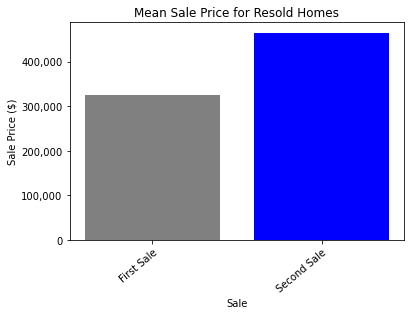

In [376]:
x_labels = ['First Sale', 'Second Sale']
plt.bar(x = x_labels, height = [df14['price'].mean(), df16['price'].mean()], color=['grey', 'blue',])
plt.xticks(rotation=40, ha="right", rotation_mode='anchor')
plt.xlabel('Sale')
plt.ylabel('Sale Price ($)')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title("Mean Sale Price for Resold Homes")
plt.savefig('./images/resale_price', bbox_inches='tight', dpi=300);

To calculate a percentage of improvement in sale price of homes that were resold:

In [377]:
(df16['price'].mean() - df14['price'].mean()) / df14['price'].mean()

0.42579723905805666

The average sale price increased by 42.6% upon resale.

In [378]:
model4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,1.365e+05,6607.716,20.660,0.000,1.23e+05,1.5e+05
bedrooms,1.109e+04,8438.376,1.314,0.191,-5580.594,2.78e+04
bathrooms,2698.3681,1.15e+04,0.235,0.814,-1.99e+04,2.53e+04
sqft_living,2.356e+04,1.66e+04,1.416,0.159,-9300.215,5.64e+04
sqft_lot,1.159e+04,1.25e+04,0.926,0.356,-1.31e+04,3.63e+04
floors,-1357.1252,1.02e+04,-0.132,0.895,-2.16e+04,1.89e+04
sqft_above,-1.587e+04,1.45e+04,-1.092,0.277,-4.46e+04,1.28e+04
yr_built,-2.769e+04,9719.247,-2.848,0.005,-4.69e+04,-8487.692
sqft_living15,-6272.0216,1.07e+04,-0.585,0.560,-2.75e+04,1.49e+04
sqft_lot15,-1.713e+04,1.27e+04,-1.348,0.180,-4.22e+04,7977.546


The p-values for our features indicate only the distance from Seattle ("dist_Seattle) and the "yr_built" are statistically significant to our model

# Summary

In summary, for the business goals of Northwest Builders & Renovation to understand the most relevant factors affecting home sale price, and maximizing marketing possibilities for renovations and new builds, we would recommend focusing on the location of the property, size of the property, and the size of the nearest homes to the property.  Based on the calculations from our final model, there is a decrease in sale price of 16,271 dollars per mile *away* from downtown Seattle, an increase in sale price by 115 dollars per square foot added in the living area of the property, and an increase in sale price of 110 dollars per square foot added in the living area of the nearest 15 homes.  We also found significance in the features of distance from Seattle and year built affecting the change in resale price for properties in our dataset. We found on average, sale prices increased by 42% from first sale to second sale.  